In [1]:
from discopy import PRO, Ty
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [3]:
from combinators import lens, sampler, utils
from combinators.inference import conditioning
import examples.gmm.gmm as gmm

In [4]:
cluster_precisions = torch.from_numpy(np.load('data/gmm/precision.npy'))
cluster_means = torch.from_numpy(np.load('data/gmm/mean.npy'))
zs_ground_truth = torch.from_numpy(np.load('data/gmm/assignment.npy'))
xs = torch.from_numpy(np.load('data/gmm/ob.npy'))

In [5]:
D = xs.shape[2]
K = zs_ground_truth.shape[2]
N = xs.shape[1]
NUM_SAMPLES = xs.shape[0]

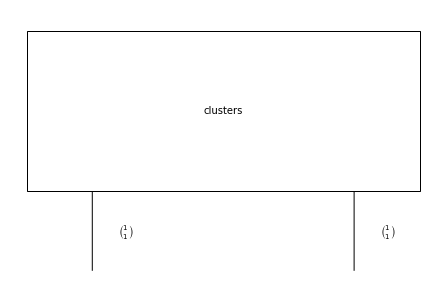

In [6]:
prior = gmm.GaussianClusters(K, D)
gibbs = gmm.ClustersGibbs(K, D)
clusters_prior = sampler.importance_box('clusters', prior, (NUM_SAMPLES,), gibbs, PRO(0), PRO(2))
clusters_prior.draw()

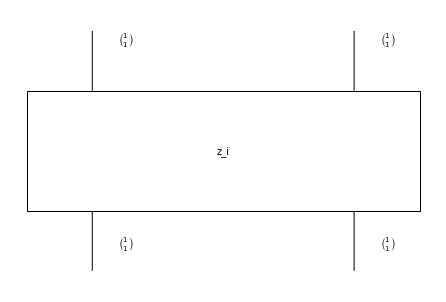

In [7]:
prior = gmm.SampleCluster(K, N)
gibbs = gmm.AssignmentGibbs()
cluster_latent = sampler.importance_box('z_i', prior, (NUM_SAMPLES,), gibbs, PRO(2), PRO(2))
cluster_latent.draw()

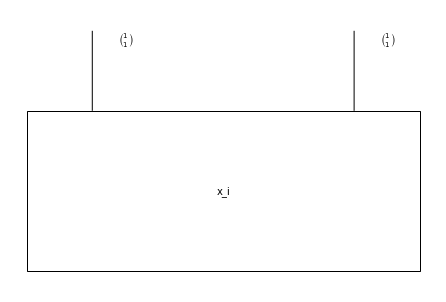

In [8]:
likelihood = gmm.SamplePoint()
gibbs = gmm.ObservationGibbs()

likelihood = sampler.importance_box('x_i', likelihood, (NUM_SAMPLES,), gibbs, PRO(2), PRO(0))
likelihood = conditioning.SequentialConditioner(x_i=xs)(likelihood)
likelihood.draw()

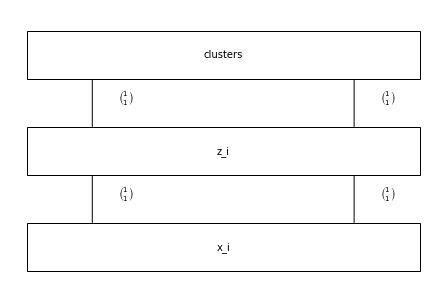

In [9]:
model = clusters_prior >> cluster_latent >> likelihood
model.draw()

In [10]:
FIGSIZE = 6
COLORS = ['#AA3377', '#EE7733', '#0077BB', '#009988', '#555555', '#999933']

def viz_data(xs, zs, means, precisions, bound=40):
    fig, ax = plt.subplots(figsize=(FIGSIZE, FIGSIZE))
    for k in range(K):
        cov_k = np.diag(1. / precisions[k].numpy())
        xs_k = xs[zs == k].numpy()
        ax.scatter(xs_k[:, 0], xs_k[:, 1], c=COLORS[k], zorder=3)
        utils.plot_cov_ellipse(cov=cov_k, pos=means[k], nstd=2, color=COLORS[k], ax=ax, alpha=0.3, zorder=3)
    
    ax.set_ylim([-bound, bound])
    ax.set_xlim([-bound, bound])
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.show()
    plt.close()

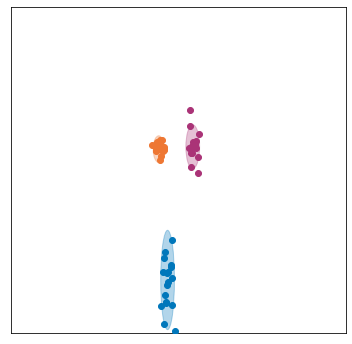

In [11]:
viz_data(xs[0], zs_ground_truth[0].argmax(dim=-1), cluster_means[0], cluster_precisions[0])

In [12]:
graph = sampler.compile(model)
_ = sampler.filter(graph)
p_orig, log_weight = sampler.trace(graph)

In [13]:
p_orig['x'].log_prob.sum()

tensor(-5514.0768, dtype=torch.float64)

In [14]:
log_weight

tensor([-5514.0768], dtype=torch.float64)

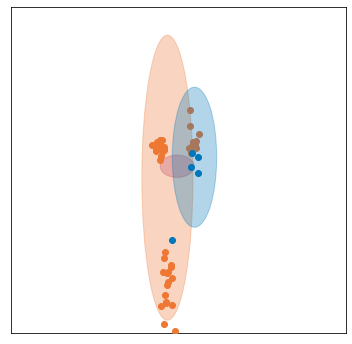

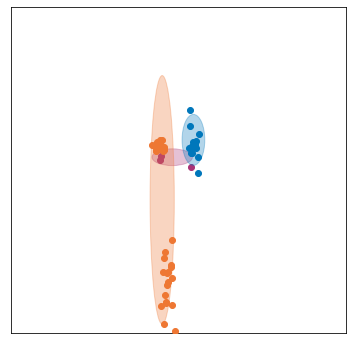

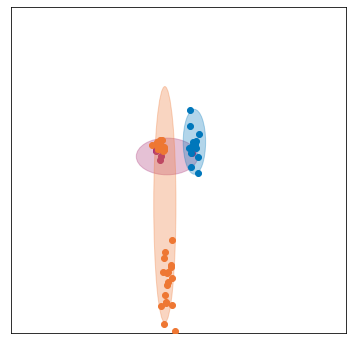

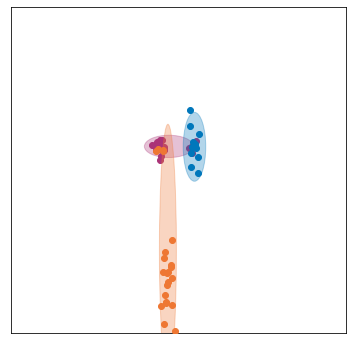

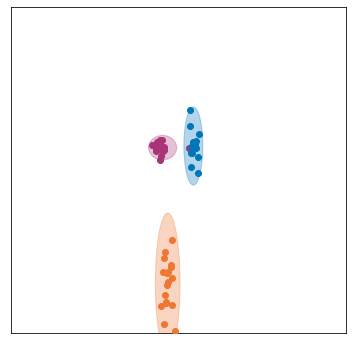

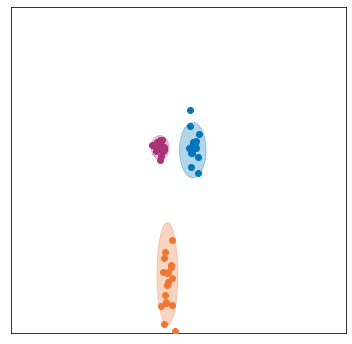

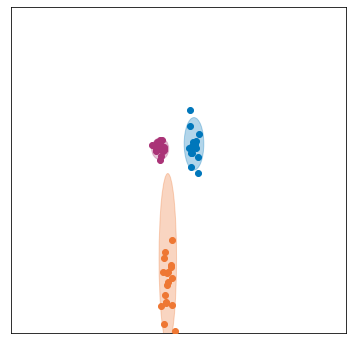

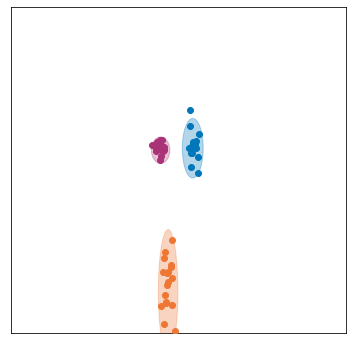

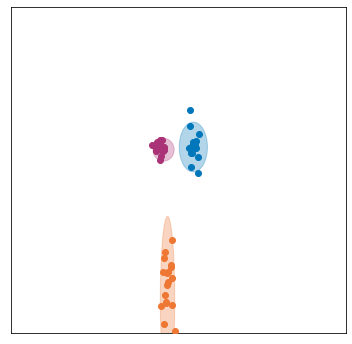

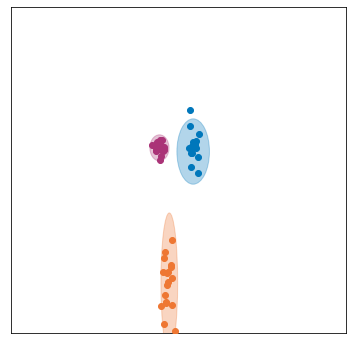

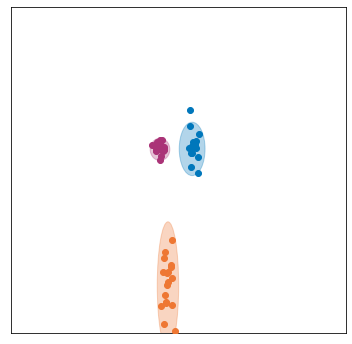

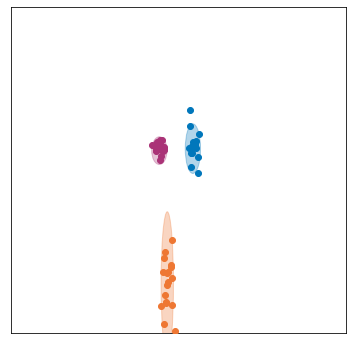

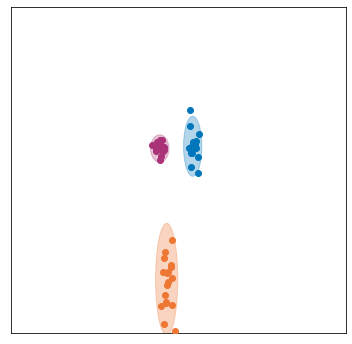

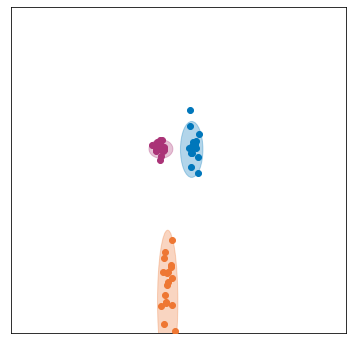

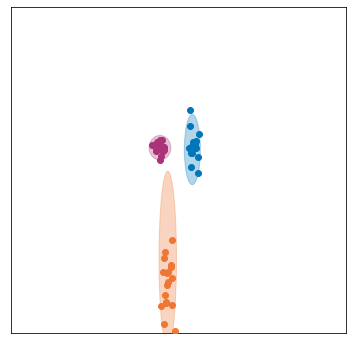

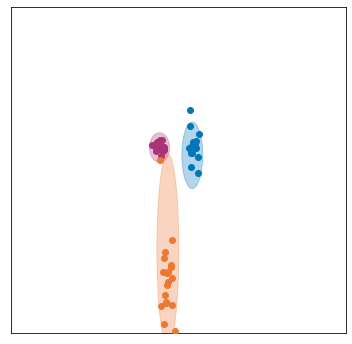

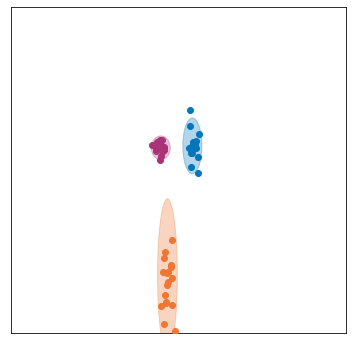

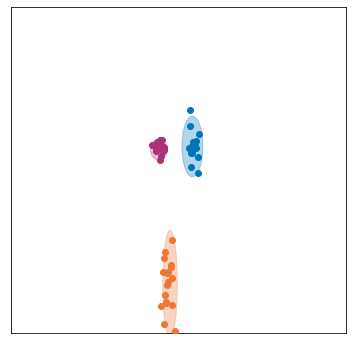

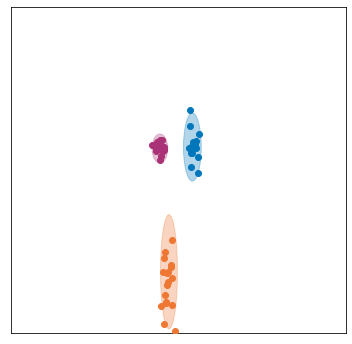

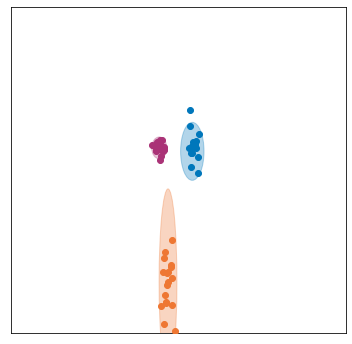

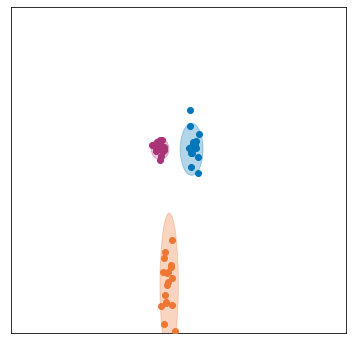

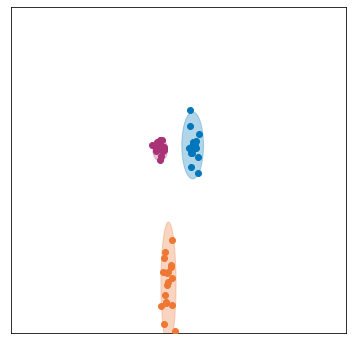

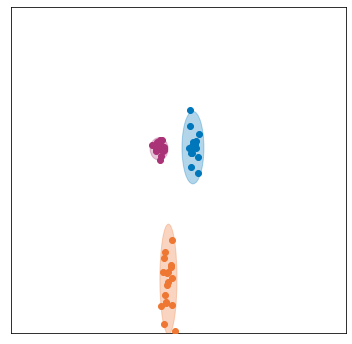

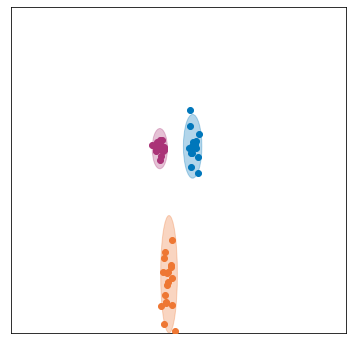

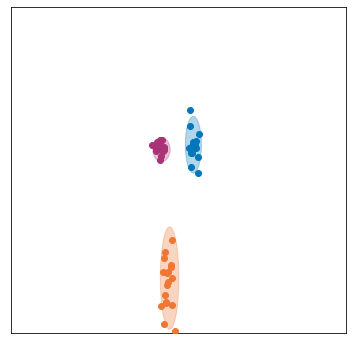

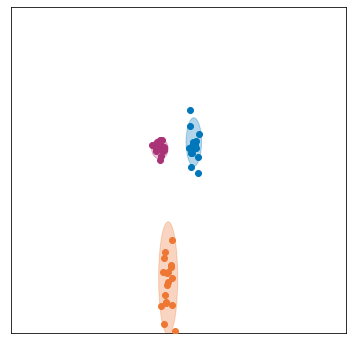

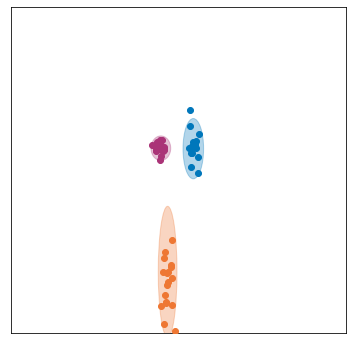

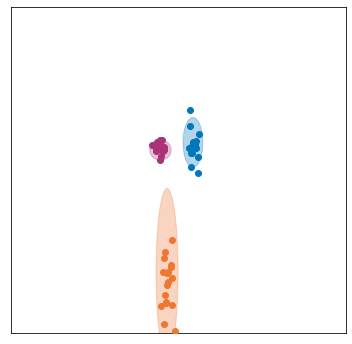

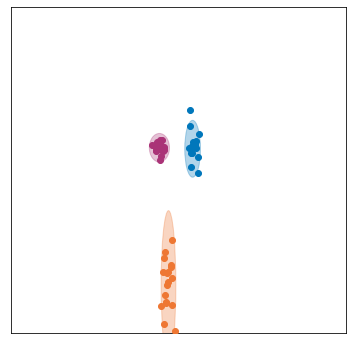

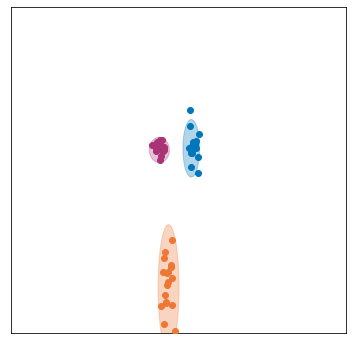

In [15]:
for _ in range(30):
    sampler.smooth(graph)
    p, log_weight = sampler.trace(graph)

    assert p != p_orig
    estimated_means = p['mu'].value[0]
    estimated_precisions = p['tau'].value[0]
    estimated_zs = p['z'].value[0]
    
    viz_data(xs[0], estimated_zs, estimated_means, estimated_precisions)

In [16]:
sampler.filter(graph)
p, log_weight = sampler.trace(graph)

In [17]:
log_weight

tensor([-3549.1270], dtype=torch.float64)

In [18]:
p['x'].log_prob.sum()

tensor(-3504.9652, dtype=torch.float64)